### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

sys.path.append("../src/")
from seq2seq import Seq2SeqModel

In [2]:
plt.style.use("bmh")
warnings.filterwarnings(action="ignore")
np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Functions

In [3]:
def train(model, train_dataloader, test_dataloader, lr, n_epochs=1_000):
    train_loss = []
    test_loss = []

    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    criterion = torch.nn.MSELoss()

    tqdm_bar = tqdm(range(1, 1 + n_epochs), "Training")
    
    for epoch in tqdm_bar:
        model.train()
        epoch_train_loss = 0
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(targets, outputs)
            epoch_train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss.append(epoch_train_loss)

        model.eval()
        epoch_test_loss = 0
        with torch.no_grad():
            for inputs, targets in test_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(targets, outputs)
                epoch_test_loss += loss.item()
        test_loss.append(epoch_test_loss)

        tqdm_bar.set_description(f"[Epoch {epoch}/{n_epochs}] train loss = {epoch_train_loss:.2f} test loss = {epoch_test_loss:.2f}")

    return train_loss, test_loss

## Synthetic data

## ECG 50000

In [4]:
DATA_PATH = "../data/"

In [5]:
ecg_train = np.array(pd.read_table(DATA_PATH + "ECG5000/ECG5000_TRAIN.tsv"))[:, :, np.newaxis]
ecg_test = np.array(pd.read_table(DATA_PATH + "ECG5000/ECG5000_TEST.tsv"))[:, :, np.newaxis]

In [6]:
ecg_train.shape, ecg_test.shape

((499, 141, 1), (4499, 141, 1))

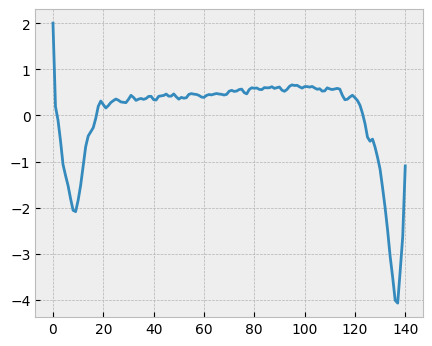

In [7]:
plt.figure(figsize=(5, 4))
plt.plot(ecg_train[333])
plt.show()

In [8]:
class ECG5000Dataset(Dataset):

    def __init__(self, data, output_length=56):
        self.data = torch.from_numpy(data).to(dtype=torch.float32)
        self.output_length = output_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index, :-self.output_length], self.data[index, -self.output_length:]

In [9]:
batch_size = 32
ecg_train_dataset = ECG5000Dataset(ecg_train)
ecg_test_dataset = ECG5000Dataset(ecg_test)
ecg_train_dataloader = DataLoader(ecg_train_dataset, batch_size=batch_size, shuffle=True)
ecg_test_dataloader = DataLoader(ecg_test_dataset, batch_size=batch_size, shuffle=False)

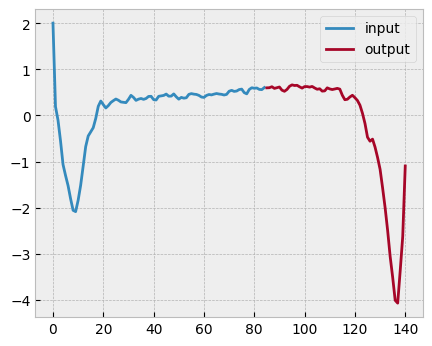

In [10]:
input, output = ecg_train_dataset[333]
input, output = input.numpy(), output.numpy()
plt.figure(figsize=(5, 4))
plt.plot(np.arange(0, len(input)), input, label="input")
plt.plot(np.arange(len(input), len(input) + len(output)), output, label="output")
plt.legend()
plt.show()

In [11]:
lr = 1e-3
n_epochs = 100
model = Seq2SeqModel(output_length=56, input_size=1, hidden_size=128, projection_size=16, num_layers=1, device=device)
train_loss, test_loss = train(model, ecg_train_dataloader, ecg_test_dataloader, lr, n_epochs)

[Epoch 100/100] train loss = 3.27 test loss = 32.19: 100%|██████████| 100/100 [04:45<00:00,  2.85s/it]


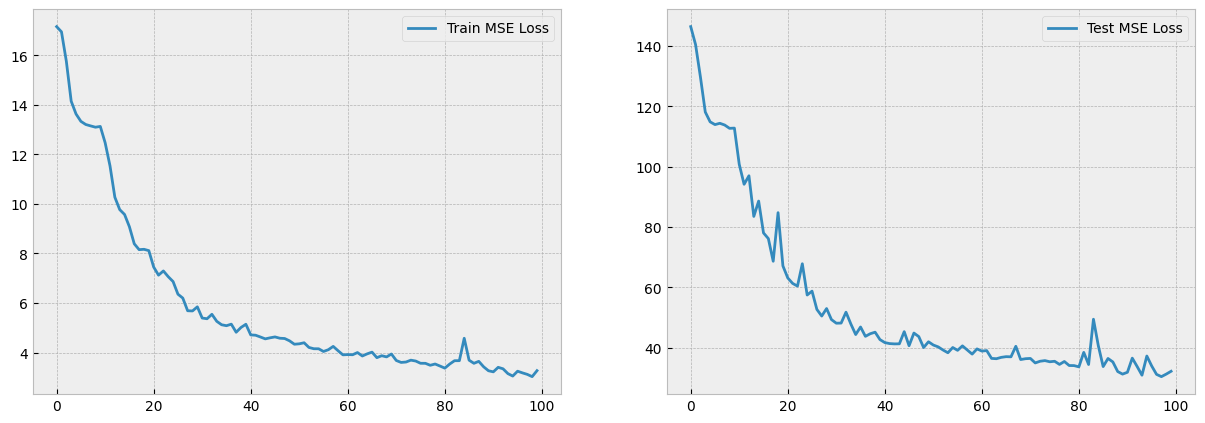

In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train MSE Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(test_loss, label="Test MSE Loss")
plt.legend()
plt.show()

## Traffic